# Deep Learning

In [2]:
# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

In [7]:
def create_placeholders(n_x):
    """
    Creates the placeholders for the tensorflow session.
    
    Arguments:
    n_x -- scalar, size of an image vector (num_px * num_px = 64 * 64 * 3 = 12288)
    n_y -- scalar, number of classes (from 0 to 5, so -> 6)
    
    Returns:
    X -- placeholder for the data input, of shape [n_x, None] and dtype "float"
    Y -- placeholder for the input labels, of shape [n_y, None] and dtype "float"
    
    Tips:
    - You will use None because it let's us be flexible on the number of examples you will for the placeholders.
      In fact, the number of examples during test/train is different.
    """
    
    X = tf.placeholder(tf.float32, shape=(None, n_x), name="X")
    Y = tf.placeholder(tf.int64, shape=(None,), name="Y")
    training = tf.placeholder_with_default(False, shape=(), name='training')  # istraining flag for batch_normalization()
    
    return X, Y, training

In [8]:
def forward_propagation(X, layer_hidden_nums, training, dropout_rate, regularizer_scale):
    """
    Implements the forward propagation for the model
    
    Arguments:
    X -- input dataset placeholder, of shape (input size, number of examples)

    Returns:
    Z5 -- the output of the last LINEAR unit
    """
    he_init = tf.contrib.layers.variance_scaling_initializer()
    l1_regularizer = tf.contrib.layers.l1_regularizer(regularizer_scale) 
    
    A_drop = X
    for layer_index, layer_neurons in enumerate(layer_hidden_nums[:-1]):
        Z = tf.layers.dense(inputs=A_drop, units=layer_neurons, kernel_initializer=he_init, kernel_regularizer=l1_regularizer, name="hidden%d" % (layer_index + 1))
        Z_nor = tf.layers.batch_normalization(Z, training=training, momentum=0.9)
        A = tf.nn.elu(Z_nor)
        A_drop = tf.layers.dropout(A, dropout_rate, training=training, name="hidden%d_drop" % (layer_index + 1))
        
    # don't do normalization for the output layer
    Z_output = tf.layers.dense(inputs=A_drop, units=layer_hidden_nums[-1], kernel_initializer=he_init, name="output")
    #Z_output_nor = tf.layers.batch_normalization(Z_output, training=training, momentum=0.9)
    
    return Z_output

In [15]:
def compute_cost(Z_output, Y):
    """
    Computes the cost
    
    Arguments:
    Z_output -- output of forward propagation (output of the last LINEAR unit), of shape (number of examples, layer_hidden_nums[4]=1)
    Y -- label, size of (number of examples, 1)
    
    Returns:
    cost - Tensor of the cost function
    """

    cost = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=Y, logits=Z_output))   
    return cost

In [10]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt


def model(X_train, Y_train, X_test, Y_test, learning_rate=0.0001, dropout_rate=0.1, regularizer_scale=0.01,
          num_epochs=120, minibatch_size=32, print_cost=True):
    (m, n_x) = X_train.shape
    costs = []                                        # To keep track of the cost
    X, Y, training = create_placeholders(n_x)
    layer_hidden_nums = [200, 100, 50, 25, 5]
    Z5 = forward_propagation(X, layer_hidden_nums, training, dropout_rate, regularizer_scale)
    cost = compute_cost(Z5, Y)
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)
    correct = tf.nn.in_top_k(Z5, Y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name='accuracy')
    
    # Initialize all the variables
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()
    
    # Start the session to compute the tensorflow graph
    with tf.Session() as sess:
        # Run the initialization
        sess.run(init)
        for epoch in range(num_epochs):
            epoch_cost = 0
            shuffled_idx = np.random.permutation(m)
            num_minibatches = X_train.shape[0] // minibatch_size
            batches = np.array_split(shuffled_idx, num_minibatches)
            
            for batch in batches:
                X_batch, Y_batch = X_train[batch], Y_train[batch]
                # for training, need to set flag training of batch_normalization() to true
                _, minibatch_cost = sess.run([optimizer, cost], feed_dict={training: True, X: X_batch, Y: Y_batch})  
                epoch_cost += minibatch_cost / num_minibatches
                
            if epoch % 10 == 0:
                acc_train = accuracy.eval(feed_dict={X: X_train, Y: Y_train})  # for testing, leave training param for batch_normalization() to false
                acc_test = accuracy.eval(feed_dict={X: X_test, Y: Y_test})
                print(epoch, "Train accuracy: ", acc_train, "Test accuracy: ", acc_test)
            # Print the cost every epoch
            if print_cost is True and epoch % 20 == 0:
                print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
            if print_cost is True and epoch % 5 == 0:
                costs.append(epoch_cost)
                
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()
        
        save_path = saver.save(sess, "C:\Boyuan\MyPython\SavedModel\FiveLayerNNForMNist\my_model_final.ckpt")

In [50]:
from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets("/tmp/data/")
X_train1 = mnist.train.images[mnist.train.labels < 5]
y_train1 = mnist.train.labels[mnist.train.labels < 5]
X_valid1 = mnist.validation.images[mnist.validation.labels < 5]
y_valid1 = mnist.validation.labels[mnist.validation.labels < 5]
X_test1 = mnist.test.images[mnist.test.labels < 5]
y_test1 = mnist.test.labels[mnist.test.labels < 5]

Extracting /tmp/data/train-images-idx3-ubyte.gz


Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [2]:
X_train1.shape

(28038, 784)

In [3]:
len(X_train1)

28038

In [10]:
y_train1.shape

(28038,)

In [41]:
y_train1

array([3, 4, 1, ..., 2, 1, 3], dtype=uint8)

0 Train accuracy:  0.953206 Test accuracy:  0.955633
Cost after epoch 0: 0.410409


10 Train accuracy:  0.961802 Test accuracy:  0.95505


20 Train accuracy:  0.957986 Test accuracy:  0.94999
Cost after epoch 20: 0.027612


30 Train accuracy:  0.965796 Test accuracy:  0.956996


40 Train accuracy:  0.962265 Test accuracy:  0.957774
Cost after epoch 40: 0.014173


50 Train accuracy:  0.977138 Test accuracy:  0.965363


60 Train accuracy:  0.984307 Test accuracy:  0.977038
Cost after epoch 60: 0.012476


70 Train accuracy:  0.981026 Test accuracy:  0.974509


80 Train accuracy:  0.967936 Test accuracy:  0.962444
Cost after epoch 80: 0.006885


90 Train accuracy:  0.977994 Test accuracy:  0.968087


100 Train accuracy:  0.996433 Test accuracy:  0.988714
Cost after epoch 100: 0.005754


110 Train accuracy:  0.991155 Test accuracy:  0.983071


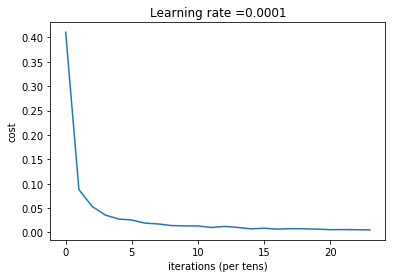

In [12]:
reset_graph()

model(X_train1, y_train1, X_test1, y_test1)

# Transfer Learning

## 1. Reuse and freez layers before output layer ## 

In [105]:
import tensorflow as tf
import numpy as np

reset_graph()
saver = tf.train.import_meta_graph("C:\Boyuan\MyPython\SavedModel\FiveLayerNNForMNist\my_model_final.ckpt.meta")
for op in tf.get_default_graph().get_operations():
    print(op.name)

In [52]:
from IPython.display import clear_output, Image, display, HTML

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = b"<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

In [19]:
show_graph(tf.get_default_graph())

In [53]:
reset_graph()

In [54]:
def restore_placeholders():
    X = tf.get_default_graph().get_tensor_by_name("X:0")
    Y = tf.get_default_graph().get_tensor_by_name("Y:0")
    return X, Y

In [13]:
def restore_forward_propagation(output_neural_num, regularizer_scale):
    he_init = tf.contrib.layers.variance_scaling_initializer()
    l1_regularizer = tf.contrib.layers.l1_regularizer(regularizer_scale)
    
    hidden4 = tf.get_default_graph().get_tensor_by_name("hidden4_drop/cond/Merge:0")
    Z_output_new = tf.layers.dense(inputs=hidden4, units=output_neural_num, kernel_initializer=he_init, kernel_regularizer=l1_regularizer, name="output_new")
    return Z_output_new

In [103]:
train_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)
train_vars

[<tf.Variable 'hidden1/kernel:0' shape=(784, 200) dtype=float32_ref>,
 <tf.Variable 'hidden1/bias:0' shape=(200,) dtype=float32_ref>,
 <tf.Variable 'batch_normalization/gamma:0' shape=(200,) dtype=float32_ref>,
 <tf.Variable 'batch_normalization/beta:0' shape=(200,) dtype=float32_ref>,
 <tf.Variable 'hidden2/kernel:0' shape=(200, 100) dtype=float32_ref>,
 <tf.Variable 'hidden2/bias:0' shape=(100,) dtype=float32_ref>,
 <tf.Variable 'batch_normalization_1/gamma:0' shape=(100,) dtype=float32_ref>,
 <tf.Variable 'batch_normalization_1/beta:0' shape=(100,) dtype=float32_ref>,
 <tf.Variable 'hidden3/kernel:0' shape=(100, 50) dtype=float32_ref>,
 <tf.Variable 'hidden3/bias:0' shape=(50,) dtype=float32_ref>,
 <tf.Variable 'batch_normalization_2/gamma:0' shape=(50,) dtype=float32_ref>,
 <tf.Variable 'batch_normalization_2/beta:0' shape=(50,) dtype=float32_ref>,
 <tf.Variable 'hidden4/kernel:0' shape=(50, 25) dtype=float32_ref>,
 <tf.Variable 'hidden4/bias:0' shape=(25,) dtype=float32_ref>,
 <tf

In [26]:
import matplotlib.pyplot as plt
import time


def restore_model(X_train, Y_train, X_test, Y_test, learning_rate=0.0001, regularizer_scale=0.01,
          num_epochs=300, minibatch_size=32, print_cost=True):
    (m, n_x) = X_train.shape
    costs = []                                        # To keep track of the cost
    saver = tf.train.import_meta_graph("C:\Boyuan\MyPython\SavedModel\FiveLayerNNForMNist\my_model_final.ckpt.meta")
    X, Y = restore_placeholders()
    output_neural_num = 5
    Z5 = restore_forward_propagation(output_neural_num, regularizer_scale)
    with tf.name_scope("new_loss"):
        cost = compute_cost(Z5, Y)
    with tf.name_scope("new_train"):
        train_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope="output_new")
        optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate, name='Adam_New')\
                            .minimize(cost, var_list=train_vars)
    with tf.name_scope("new_eval"):
        correct = tf.nn.in_top_k(Z5, Y, 1)
        accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name='accuracy')
    
    # Initialize all the variables
    init = tf.global_variables_initializer()
    new_saver = tf.train.Saver()
    
    # Start the session to compute the tensorflow graph
    with tf.Session() as sess:
        # Run the initialization
        sess.run(init)
        saver.restore(sess, "C:\Boyuan\MyPython\SavedModel\FiveLayerNNForMNist\my_model_final.ckpt")
        
        t_total = 0
        
        for epoch in range(num_epochs):
            epoch_cost = 0
            shuffled_idx = np.random.permutation(m)
            num_minibatches = X_train.shape[0] // minibatch_size
            batches = np.array_split(shuffled_idx, num_minibatches)
            
            t0 = time.time()
            
            for batch in batches:
                X_batch, Y_batch = X_train[batch], Y_train[batch]
                # for training, need to set flag training of batch_normalization() to true
                _, minibatch_cost = sess.run([optimizer, cost], feed_dict={X: X_batch, Y: Y_batch})  
                epoch_cost += minibatch_cost / num_minibatches
            
            t1 = time.time()
            t_total += (t1 - t0)
            
            if epoch % 100 == 0:
                acc_train = accuracy.eval(feed_dict={X: X_train, Y: Y_train})  # for testing, leave training param for batch_normalization() to false
                acc_test = accuracy.eval(feed_dict={X: X_test, Y: Y_test})
                print(epoch, "Train accuracy: ", acc_train, "Test accuracy: ", acc_test)
            # Print the cost every epoch
            if print_cost is True and epoch % 100 == 0:
                print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
            if print_cost is True and epoch % 5 == 0:
                costs.append(epoch_cost)
        
        print("Total training time: {:.1f}s".format(t_total))
                
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()
        
        save_path = new_saver.save(sess, "C:\Boyuan\MyPython\SavedModel\FiveLayerNNForMNist_New\my_model_final.ckpt")

In [5]:
from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets("/tmp/data/")
X_train2_full = mnist.train.images[mnist.train.labels >= 5]
y_train2_full = mnist.train.labels[mnist.train.labels >= 5] - 5
X_valid2_full = mnist.validation.images[mnist.validation.labels >= 5]
y_valid2_full = mnist.validation.labels[mnist.validation.labels >= 5] - 5
X_test2 = mnist.test.images[mnist.test.labels >= 5]
y_test2 = mnist.test.labels[mnist.test.labels >= 5] - 5

Extracting /tmp/data/train-images-idx3-ubyte.gz


Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [6]:
def sample_n_instance_per_class(X, y, n=100):
    Xs, ys = [], []
    for label in np.unique(y):
        index = (y == label)
        X_index = X[index][:n]
        y_index = y[index][:n]
        Xs.append(X_index)
        ys.append(y_index)
    return np.concatenate(Xs), np.concatenate(ys)    

In [7]:
X_train2, y_train2 = sample_n_instance_per_class(X_train2_full, y_train2_full, n=100)
X_valid2, y_valid2 = sample_n_instance_per_class(X_valid2_full, y_valid2_full, 30)

In [89]:
X_train2.shape

(500, 784)

In [90]:
y_train2.shape

(500,)

INFO:tensorflow:Restoring parameters from C:\Boyuan\MyPython\SavedModel\FiveLayerNNForMNist\my_model_final.ckpt


0 Train accuracy:  0.2 Test accuracy:  0.160667
Cost after epoch 0: 3.790387


100 Train accuracy:  0.742 Test accuracy:  0.703559
Cost after epoch 100: 0.760816


200 Train accuracy:  0.8 Test accuracy:  0.743674
Cost after epoch 200: 0.601591


300 Train accuracy:  0.832 Test accuracy:  0.757663
Cost after epoch 300: 0.530518


400 Train accuracy:  0.852 Test accuracy:  0.764246
Cost after epoch 400: 0.489803


500 Train accuracy:  0.858 Test accuracy:  0.768155
Cost after epoch 500: 0.464171


600 Train accuracy:  0.868 Test accuracy:  0.770829
Cost after epoch 600: 0.446915


700 Train accuracy:  0.868 Test accuracy:  0.77124
Cost after epoch 700: 0.432890


800 Train accuracy:  0.87 Test accuracy:  0.771652
Cost after epoch 800: 0.423068


900 Train accuracy:  0.876 Test accuracy:  0.772269
Cost after epoch 900: 0.414426


Total training time: 46.5s


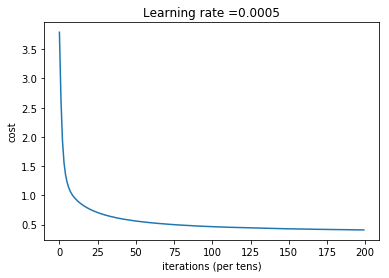

In [27]:
reset_graph()

restore_model(X_train2, y_train2, X_test2, y_test2, num_epochs=1000, minibatch_size=24, learning_rate=0.0005)

## 2. Caching the frozen layers ## 

In [24]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import time

def restore_model_with_caching(X_train, Y_train, X_test, Y_test, learning_rate=0.0001, regularizer_scale=0.01,
          num_epochs=300, minibatch_size=32, print_cost=True):
    (m, n_x) = X_train.shape
    costs = []                                        # To keep track of the cost
    saver = tf.train.import_meta_graph("C:\Boyuan\MyPython\SavedModel\FiveLayerNNForMNist\my_model_final.ckpt.meta")
    X, Y = restore_placeholders()
    output_neural_num = 5
    Z5 = restore_forward_propagation(output_neural_num, regularizer_scale)
    with tf.name_scope("new_loss"):
        cost = compute_cost(Z5, Y)
    with tf.name_scope("new_train"):
        train_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope="output_new")
        optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate, name='Adam_New')\
                            .minimize(cost, var_list=train_vars)
    with tf.name_scope("new_eval"):
        correct = tf.nn.in_top_k(Z5, Y, 1)
        accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name='accuracy')
    
    hidden4 = tf.get_default_graph().get_tensor_by_name("hidden4_drop/cond/Merge:0")
    
    # Initialize all the variables
    init = tf.global_variables_initializer()
    new_saver = tf.train.Saver()
    
    # Start the session to compute the tensorflow graph
    with tf.Session() as sess:
        # Run the initialization
        sess.run(init)
        saver.restore(sess, "C:\Boyuan\MyPython\SavedModel\FiveLayerNNForMNist\my_model_final.ckpt")
        
        hidden4_train = hidden4.eval(feed_dict={X: X_train, Y: Y_train})
        
        t_total = 0
        
        for epoch in range(num_epochs):
            epoch_cost = 0
            shuffled_idx = np.random.permutation(m)
            num_minibatches = X_train.shape[0] // minibatch_size
            batches = np.array_split(shuffled_idx, num_minibatches)
            
            t0 = time.time()
            
            for batch in batches:
                hidden4_batch, Y_batch = hidden4_train[batch], Y_train[batch]
                # for training, need to set flag training of batch_normalization() to true
                _, minibatch_cost = sess.run([optimizer, cost], feed_dict={hidden4: hidden4_batch, Y: Y_batch})  
                epoch_cost += minibatch_cost / num_minibatches
                
            t1 = time.time()
            t_total += (t1 - t0)
                
            if epoch % 100 == 0:
                acc_train = accuracy.eval(feed_dict={X: X_train, Y: Y_train})  # for testing, leave training param for batch_normalization() to false
                acc_test = accuracy.eval(feed_dict={X: X_test, Y: Y_test})
                print(epoch, "Train accuracy: ", acc_train, "Test accuracy: ", acc_test)
            # Print the cost every epoch
            if print_cost is True and epoch % 100 == 0:
                print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
            if print_cost is True and epoch % 5 == 0:
                costs.append(epoch_cost)
        
        print("Total training time: {:.1f}s".format(t_total))
        
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()
        
        save_path = new_saver.save(sess, "C:\Boyuan\MyPython\SavedModel\FiveLayerNNForMNist_New\my_model_final.ckpt")

INFO:tensorflow:Restoring parameters from C:\Boyuan\MyPython\SavedModel\FiveLayerNNForMNist\my_model_final.ckpt


0 Train accuracy:  0.2 Test accuracy:  0.160667
Cost after epoch 0: 3.790387


100 Train accuracy:  0.742 Test accuracy:  0.703559
Cost after epoch 100: 0.760816


200 Train accuracy:  0.8 Test accuracy:  0.743674
Cost after epoch 200: 0.601591


300 Train accuracy:  0.832 Test accuracy:  0.757663
Cost after epoch 300: 0.530518


400 Train accuracy:  0.852 Test accuracy:  0.764246
Cost after epoch 400: 0.489803


500 Train accuracy:  0.858 Test accuracy:  0.768155
Cost after epoch 500: 0.464171


600 Train accuracy:  0.868 Test accuracy:  0.770829
Cost after epoch 600: 0.446915


700 Train accuracy:  0.868 Test accuracy:  0.77124
Cost after epoch 700: 0.432890


800 Train accuracy:  0.87 Test accuracy:  0.771652
Cost after epoch 800: 0.423068


900 Train accuracy:  0.876 Test accuracy:  0.772269
Cost after epoch 900: 0.414426


Total training time: 12.2s


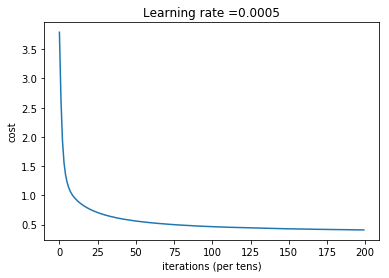

In [25]:
reset_graph()

restore_model_with_caching(X_train2, y_train2, X_test2, y_test2, num_epochs=1000, minibatch_size=24, learning_rate=0.0005)

Conclusion: Compared to the restore_model() which comsumes 45s, the restore_model_with_caching() only uses 12s, almost four times faster